In [1]:
#This whole program breaks pretty badly if another source of background is added. To fix, note that the post-processing relies on the first-letter naming
#scheme of the samples, so a new flag will need to be added for the new background and integrated with the total in block 6, and will need to be
#accounted for in the plotHists() and plotSamples() functions.

# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) 
from sidm.tools import ffschema, sidm_processor, utilities, scaleout
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
import mplhep as hep
# Load style sheet
# plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

# h, bins = np.histogram(np.random.random(1000))
# fig, ax = plt.subplots()
# hep.histplot(h, bins)

utilities.set_plot_style()

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

/home/cms-jovyan/SIDM/sidm/studies/../../sidm/tools/scaleout.py:12: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(PipInstall(packages=dependencies, pip_options=["--upgrade"]))


Connection method: Direct,
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,
Comm: tls://192.168.202.28:8786,Workers: 0
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,Total threads: 0
Started: 1 hour ago,Total memory: 0 B


In [3]:
samples = [
    "DYJetsToLL_M10to50", # Background
    "DYJetsToLL_M50",
    
    "QCD_Pt15to20", #Works
    "QCD_Pt20to30", #issue, needs many files to fill all histograms
    #"QCD_Pt30to50", #Broken, throws KeyError: 'akjet_ak4PFJetsCHS_jetid' -- Resolved by change to ffschema, detailed in bg_FileTests
    "QCD_Pt50to80", #Works
    "QCD_Pt80to120", #Works
    #"QCD_Pt120to170", #Broken, Exception: Failed processing file: WorkItem(dataset='QCD_Pt120to170' ...)
                        # Seems like the sample is missing an attribute, may be due to how it was made
    "QCD_Pt170to300", #Works
    "QCD_Pt300to470", #Works
    "QCD_Pt470to600", #Works
    "QCD_Pt600to800", #Works
    "QCD_Pt800to1000", #Works
    "QCD_Pt1000toInf", #Works
    
    "TTJets",
    
    "WW",
    "WZ",
    "ZZ"
]
fileset = utilities.make_fileset(samples, "ffntuple_v2") #max_files argument was removed, so it defaults to use all the files in each sample
#fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=1) #CHANGED: background appears to use v2 ntuples instead of v4

In [4]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client), #Dask isn't working; it would make running this many samples much easier
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "baseNoLj", "4mu", "2mu2e"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
hist_choice = "base"
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections
print(collection)

p = sidm_processor.SidmProcessor(
    channels, [hist_choice])

# test if processor is serializable
import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))


output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

['pv_n', 'pv_ndof', 'pv_z', 'pv_rho', 'electron_n', 'electron_pt', 'electron_eta_phi', 'photon_n', 'photon_pt', 'photon_eta_phi', 'muon_n', 'muon_pt', 'muon_eta_phi', 'muon_absD0', 'muon_absD0_lowRange', 'dsaMuon_n', 'dsaMuon_pt', 'dsaMuon_eta_phi', 'dsaMuon_absD0', 'dsaMuon_absD0_lowRange', 'lj_n', 'egmlj_n', 'lj_pt', 'egm_lj_pt', 'mu_lj_pt', 'lj0_pt', 'lj1_pt', 'lj0_e', 'lj1_e', 'lj0_dRSpread', 'lj1_dRSpread', 'lj_eta_phi', 'lj_electronN', 'lj_photonN', 'lj_electronPhotonN', 'lj_muonN', 'ljsource_n', 'ljsource_pt', 'ljsource_eta_phi', 'ljsource_charge', 'ljsource_type', 'electron_lj_dR', 'electron_lj_dR_lowRange', 'photon_lj_dR', 'photon_lj_dR_lowRange', 'photon_lj_dR_reallyLowRange', 'muon_lj_dR', 'muon_lj_dR_lowRange', 'dsaMuon_lj_dR', 'dsaMuon_lj_dR_lowRange', 'lj_lj_absdphi', 'lj_lj_invmass', 'lj_lj_invmass_lowRange', 'lj_pfIsolation05', 'lj0_pfIsolation05', 'lj1_pfIsolation05', 'lj_pfIsolationPtNoPU05', 'lj_pfIsolationPt05', 'lj_pfIsolation07', 'lj_pfIsolationPtNoPU07', 'lj_pfIs

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [5]:
# Post-processing, combines background sample cutflows and histograms into larger sets.
hist_set = hist_choice
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu[hist_set]) #To change the histograms used, swap "base" for the other collections
sample_list = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]
for sample in samples:
    if not(sample[0] == 'D') and not(sample[0] == 'Q') and not((sample[0] == 'W' or sample[0] == 'Z')) and not(sample[0] == 'T'):
        sample_list.append(sample)
#Combine Drell-Yan ----------------------------------------------------------------------
keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
DY_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
DY_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}
keys = list(output['out']["DYJetsToLL_M50"]["cutflow"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["cutflow"][k] for k in keys}
for channel in channels:
    DY_Cutflow[channel] = DY_Cutflow[channel] + temp[channel]
keys = list(output['out']["DYJetsToLL_M50"]["hists"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["hists"][k] for k in keys}    
for hist_name in collection:
    DY_Hists[hist_name] = DY_Hists[hist_name] + temp[hist_name]
#Combine QCD ----------------------------------------------------------------------------
keys = list(output['out']["QCD_Pt15to20"]["cutflow"].keys())[:]
QCD_Cutflow = {k: output['out']["QCD_Pt15to20"]["cutflow"][k] for k in keys}
keys = list(output['out']["QCD_Pt15to20"]["hists"].keys())[:]
QCD_Hists = {k: output['out']["QCD_Pt15to20"]["hists"][k] for k in keys}
for sample in samples:
    if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            QCD_Cutflow[channel] = QCD_Cutflow[channel] + temp[channel]
        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            QCD_Hists[hist_name] = QCD_Hists[hist_name] + temp[hist_name]
#Combine diboson ------------------------------------------------------------------------
keys = list(output['out']["WW"]["hists"].keys())[:]
DiBoson_Hists = {k: output['out']["WW"]["hists"][k] for k in keys}
keys = list(output['out']["WW"]["cutflow"].keys())[:]
DiBoson_Cutflow = {k: output['out']["WW"]["cutflow"][k] for k in keys}
for sample in ["WZ", "ZZ"]:
    keys = list(output['out']["WZ"]["cutflow"].keys())[:]
    temp = {k: output['out']["WZ"]["cutflow"][k] for k in keys}
    for channel in channels:
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + temp[channel]
    keys = list(output['out'][sample]["hists"].keys())[:]
    temp = {k: output['out'][sample]["hists"][k] for k in keys}
    for hist_name in collection:
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + temp[hist_name]
#Add ttbar ------------------------------------------------------------------------------
keys = list(output['out']["TTJets"]["hists"].keys())[:]
TT_Hists = {k: output['out']["TTJets"]["hists"][k] for k in keys}
keys = list(output['out']["TTJets"]["cutflow"].keys())[:]
TT_Cutflow = {k: output['out']["TTJets"]["cutflow"][k] for k in keys}
#Combine total background ---------------------------------------------------------------
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
bg_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}
keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
bg_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}
for sample in samples:
    if ((sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') or (sample[0] == 'T')) and (sample != "DYJetsToLL_M10to50"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            bg_Cutflow[channel] = bg_Cutflow[channel] + temp[channel]
        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            bg_Hists[hist_name] = bg_Hists[hist_name] + temp[hist_name]

In [6]:
#This function plots each histogram on a separate subplot, showing all samples on each subplot
def plotHists(hists, channel, errorBars, densityPlot, sample_0=sample_list, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(hists)
    if (nplots <= 5): ncol, nrow = nplots, 1
    else: ncol, nrow = 4, (nplots-1)//4 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    for i in range(nplots):
        DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
        plt.subplot(nrow, ncol, i+1)
        j = 0
        while j < len(samples):
            if "DY_Jets" in samples and DY_Flag == False:
                utilities.plot(DY_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
            elif "QCD_Jets" in samples and QCD_Flag == False:
                utilities.plot(QCD_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
            elif "DiBoson_Jets" in samples and DB_Flag == False:
                utilities.plot(DiBoson_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
            elif "TTJets" in samples and TT_Flag == False:
                utilities.plot(TT_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
            elif "Total Background" in samples and Tot_BG_Flag == False:
                utilities.plot(bg_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
            else:
                utilities.plot(out[samples[j]]["hists"][hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
            j = j + 1
        plt.legend(samples)
        plt.title(hists[i])

Row 1: Background signal sources in the 2mu2e channel.
Row 2: Background signal distribution with the total removed.
Row 3: Background in the 4mu channel.
Row 4: 4mu background with the total removed.


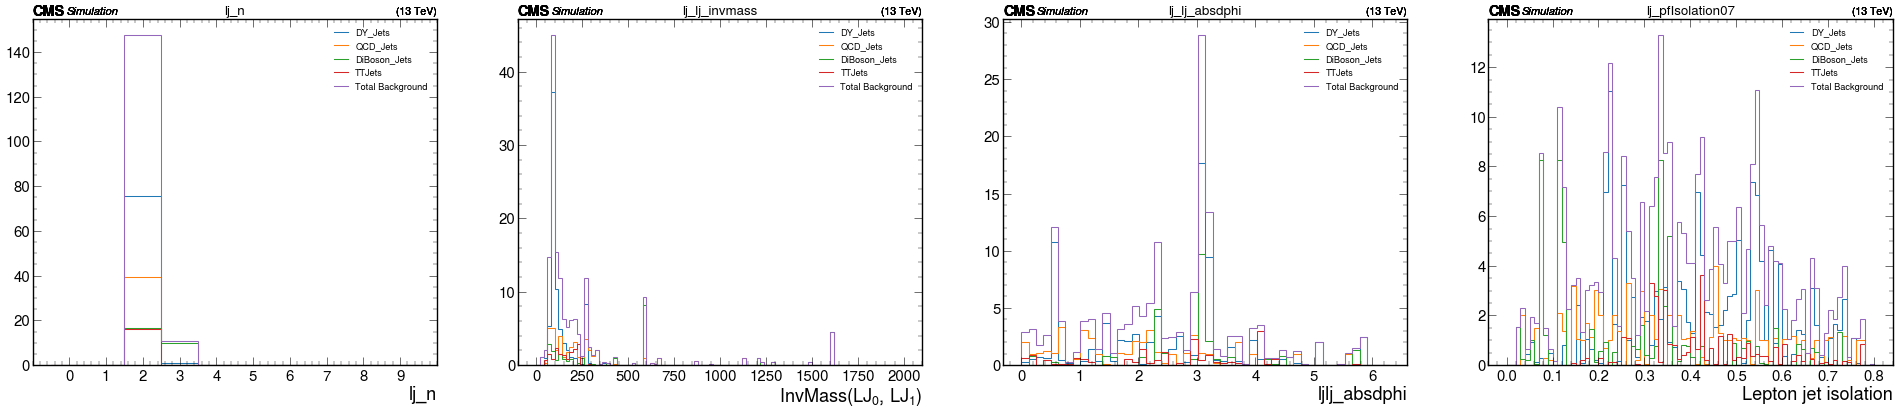

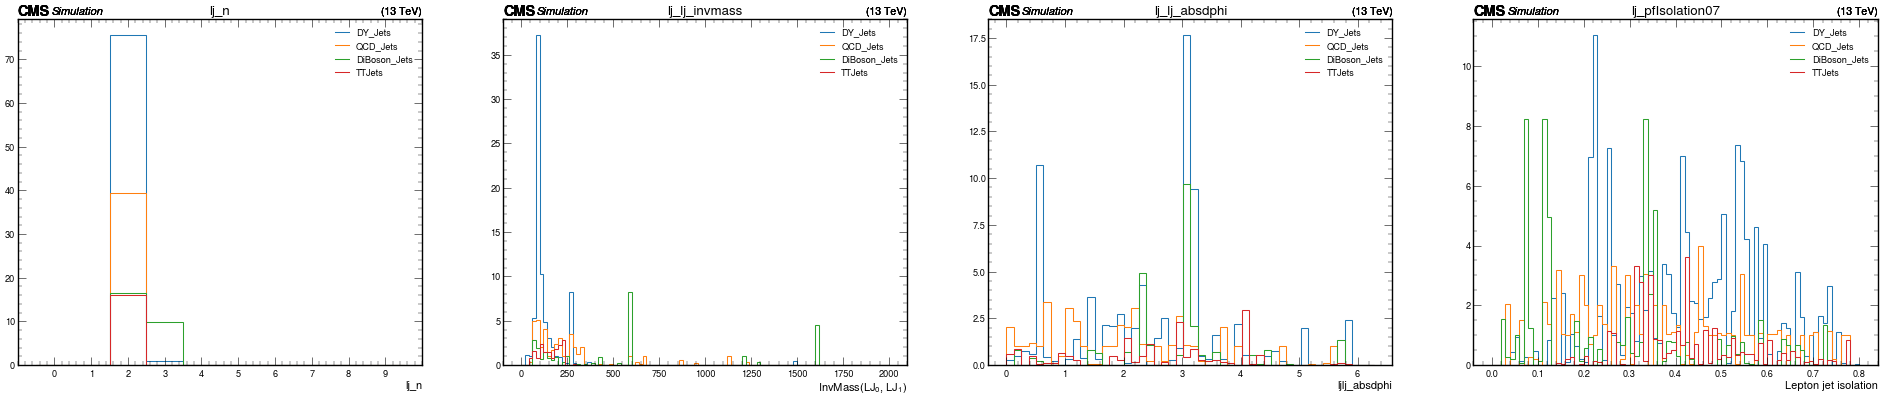

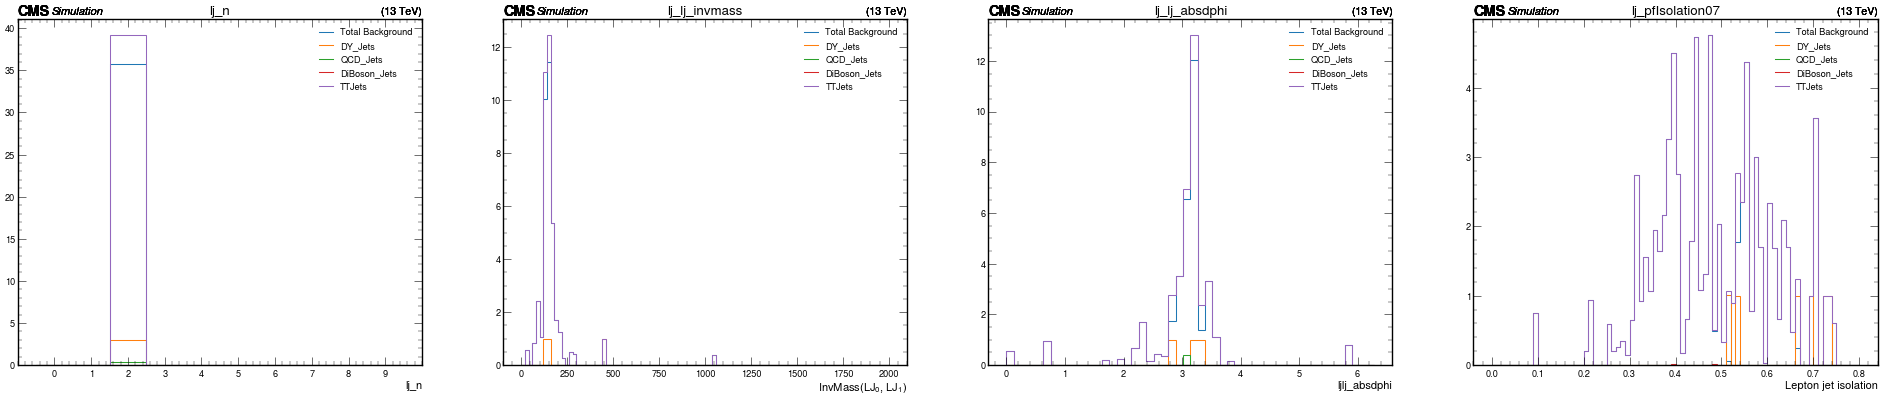

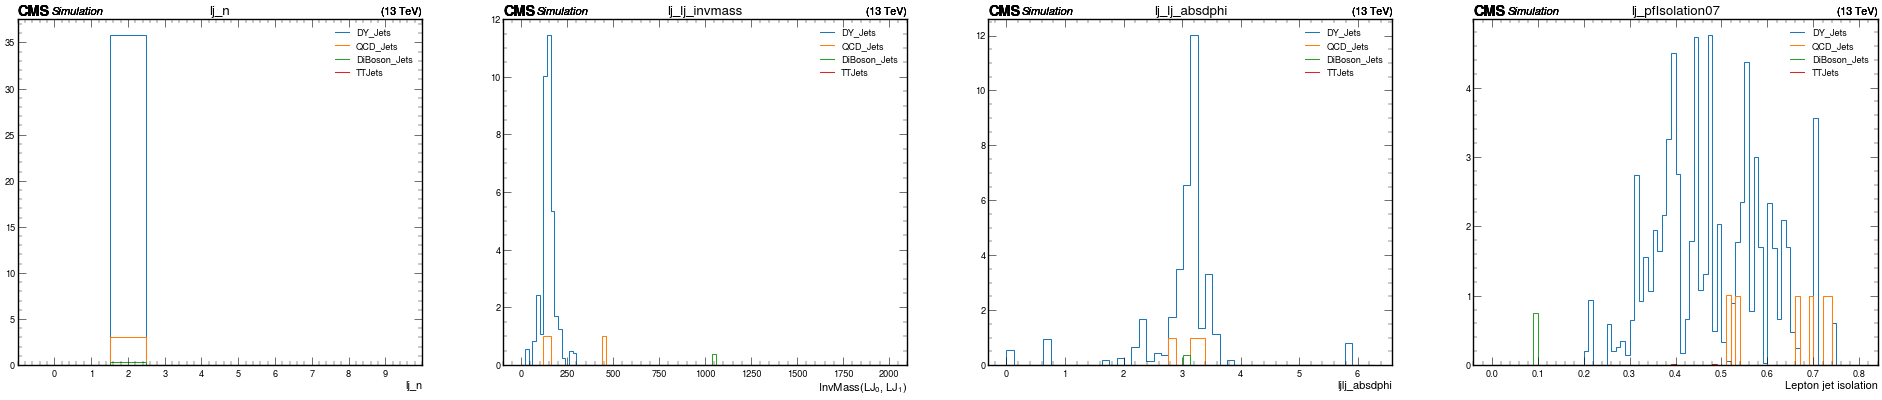

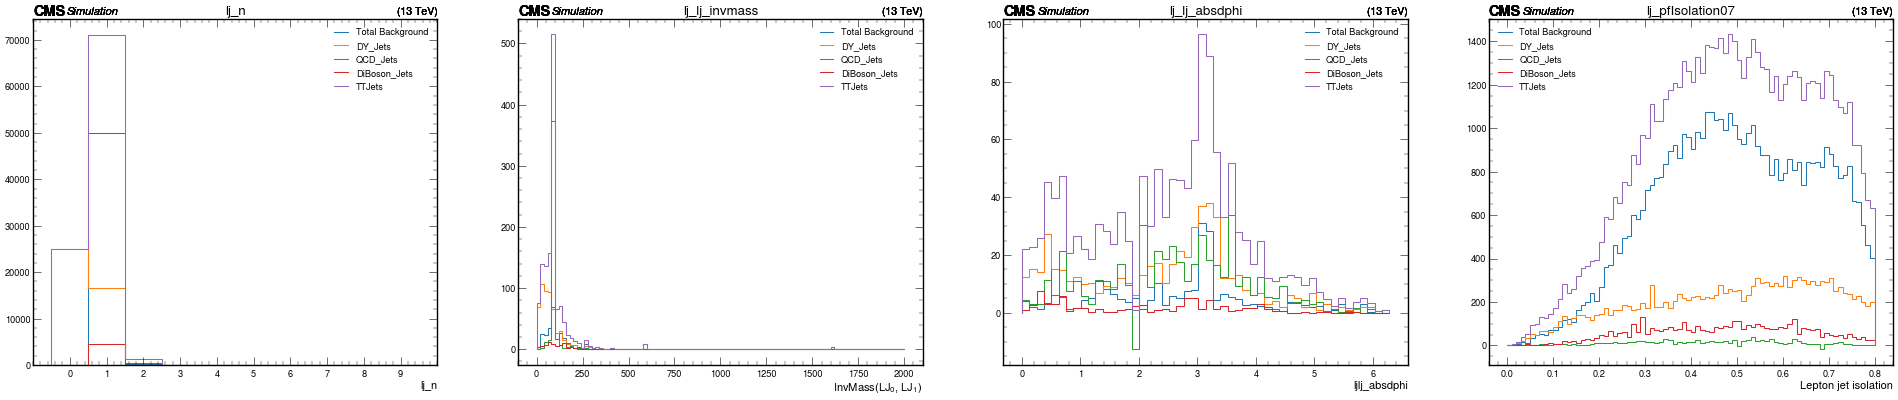

In [7]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

print("Row 1: Background signal sources in the 2mu2e channel.")
plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "2mu2e", False, False, temp)
temp.remove("Total Background")
print("Row 2: Background signal distribution with the total removed.")
plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "2mu2e", False, False, temp)
temp.insert(0, "Total Background")
print("Row 3: Background in the 4mu channel.")
plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "4mu", False, False, temp)
temp.remove("Total Background")
print("Row 4: 4mu background with the total removed.")
plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "4mu", False, False, temp)
temp.insert(0, "Total Background")
plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "baseNoLj", False, False, temp)

In [8]:
channel = "2mu2e"
init_sample = "Total Background"
samples_used = [init_sample, "DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets"]
init_cutflow = bg_Cutflow[channel]
cutflows_used = [DY_Cutflow[channel], QCD_Cutflow[channel], DiBoson_Cutflow[channel], TT_Cutflow[channel]]

init_cutflow.print_multi_table(cutflows_used, samples_used, True)
init_cutflow.print_multi_table(cutflows_used, samples_used, False)

cut name                % cuts:     % cuts:     % cuts:         % cuts:     % cuts:
                Total Background     DY_Jets    QCD_Jets    DiBoson_Jets      TTJets
------------  ------------------  ----------  ----------  --------------  ----------
No selection               100.0       100.0       100.0           100.0       100.0
PV filter                  100.0       100.0       100.0           100.0       100.0
Cosmic veto                100.0       100.0        99.9           100.0       100.0
>=2 LJs                      0.7         0.3         0.3            67.5         0.8
2mu2e                        0.2         0.2         0.1            34.4         0.4


cut name            Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                Total Background         DY_Jets        QCD_Jets    DiBoson_Jets          TTJets
------------  ------------------  --------------  --------------  --------------  --------------
No selection             9746

In [9]:
channel = "4mu"
init_sample = "Total Background"
samples_used = [init_sample, "DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets"]
init_cutflow = bg_Cutflow[channel]
cutflows_used = [DY_Cutflow[channel], QCD_Cutflow[channel], DiBoson_Cutflow[channel], TT_Cutflow[channel]]

init_cutflow.print_multi_table(cutflows_used, samples_used, True)
init_cutflow.print_multi_table(cutflows_used, samples_used, False)

print("Eff. of TBG 4mu: " + str(bg_Cutflow["4mu"].efficiency()))
print("Eff. of DB 4mu: " + str(DiBoson_Cutflow["4mu"].efficiency()))
print("Eff. of QCD basenolj: " + str(QCD_Cutflow["baseNoLj"].efficiency()))

cut name                % cuts:     % cuts:     % cuts:         % cuts:     % cuts:
                Total Background     DY_Jets    QCD_Jets    DiBoson_Jets      TTJets
------------  ------------------  ----------  ----------  --------------  ----------
No selection               100.0       100.0       100.0           100.0       100.0
PV filter                  100.0       100.0       100.0           100.0       100.0
Cosmic veto                100.0       100.0        99.9           100.0       100.0
>=2 LJs                      0.7         0.3         0.3            67.5         0.8
4mu                          0.0         0.1         0.0             0.0         0.0


cut name            Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                Total Background         DY_Jets        QCD_Jets    DiBoson_Jets          TTJets
------------  ------------------  --------------  --------------  --------------  --------------
No selection             9746

In [10]:
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
lj_base = utilities.flatten(hist_menu["lj_base"])
for hist in lj_base:
    if "eta" in hist:
        lj_base.remove(hist)

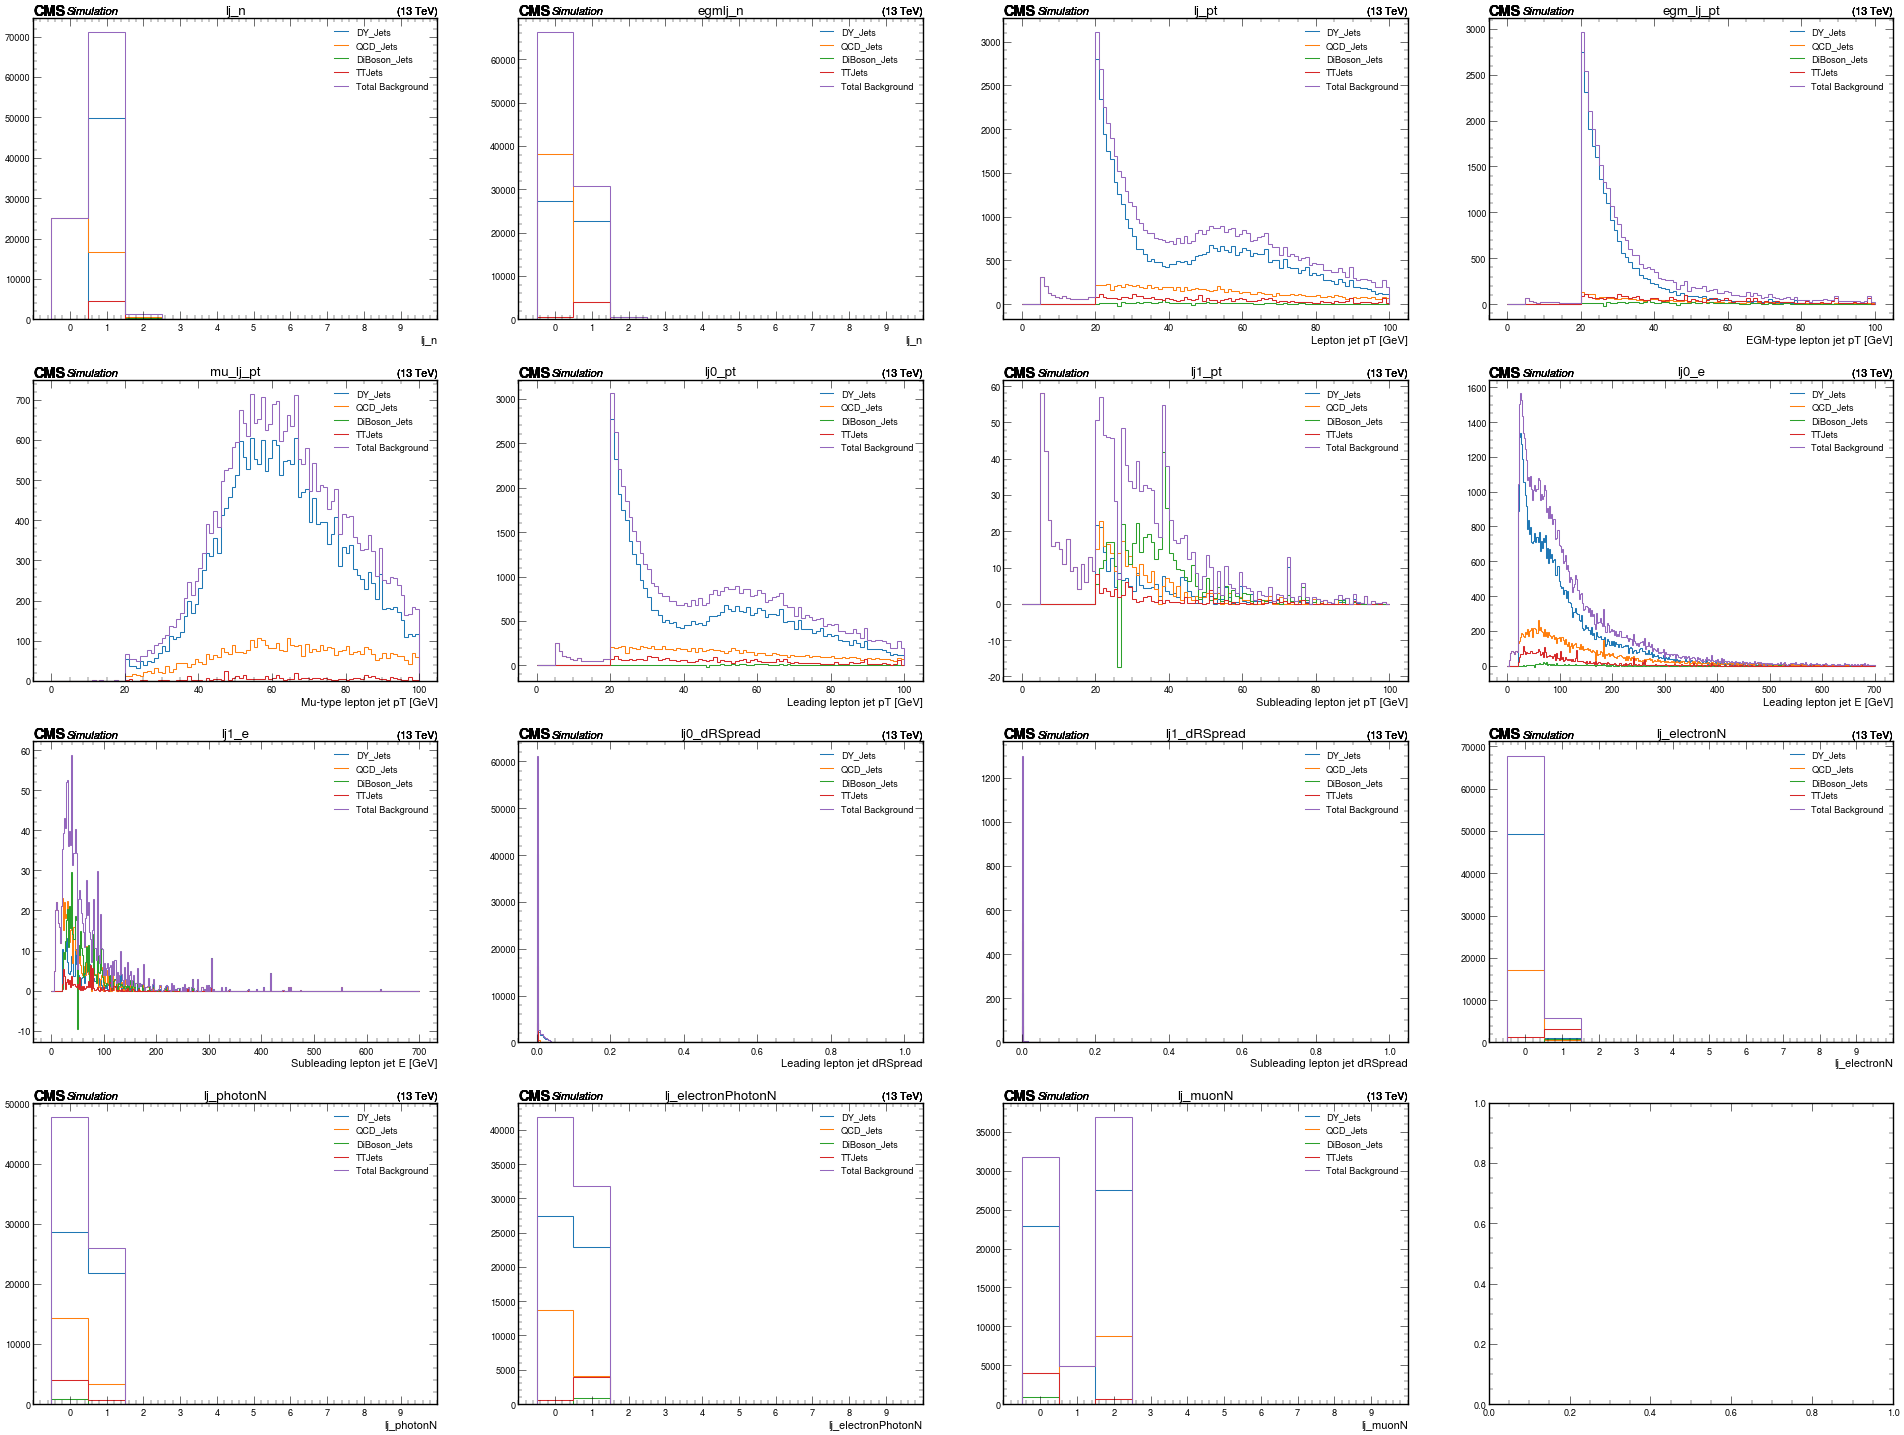

In [11]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

plotHists(lj_base, "baseNoLj", False, False, temp)

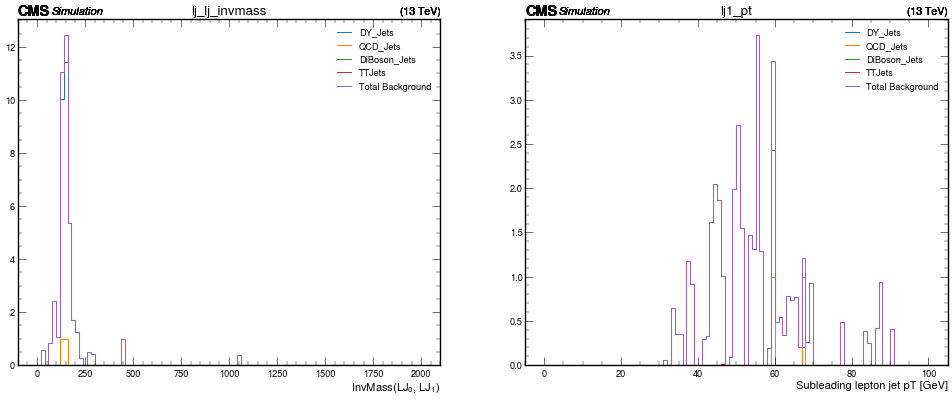

In [12]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

plotHists(["lj_lj_invmass","lj1_pt"], "4mu", False, False, temp)

In [13]:
print("2mu2e Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.\n\n")
cutflows_2mu2e = []
if 1:  
    cutflows_2mu2e.append(DY_Cutflow["2mu2e"])
    cutflows_2mu2e.append(QCD_Cutflow["2mu2e"])
    cutflows_2mu2e.append(DiBoson_Cutflow["2mu2e"])
    cutflows_2mu2e.append(TT_Cutflow["2mu2e"])
init_cutflow = bg_Cutflow["2mu2e"]
headers = [
        "Bg 2mu2e", "DY 2mu2e", "QCD 2mu2e", "DB 2mu2e", "TTbar 2mu2e"
]
init_cutflow.print_multi_table(cutflows_2mu2e, headers, False, False)
init_cutflow.print_multi_table(cutflows_2mu2e, headers, True, False)
cutValues_2mu2e = [bg_Cutflow["2mu2e"].cut_breakdown()]
for cuts in cutflows_2mu2e:
    cutValues_2mu2e.append(cuts.cut_breakdown())
headers = ["Total Background", "DY Jets", "QCD Jets", "DB Jets", "TT Jets"]
cuts_2mu2e = cutflows_2mu2e[0].cut_breakdown(giveCuts=True)

2mu2e Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.


cut name        Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                    Bg 2mu2e        DY 2mu2e       QCD 2mu2e        DB 2mu2e     TTbar 2mu2e
------------  --------------  --------------  --------------  --------------  --------------
No selection         97462.2         50149.6         42288.3            61.7          4563.1
PV filter            97462.2         50149.6         42288.3            61.7          4563.1
Cosmic veto          97421.1         50143.9         42254.0            61.7          4561.9
>=2 LJs                665.0           133.6           138.4            41.7            34.3
2mu2e                  158.5            76.5            39.5            21.2            16.2


cut name        % cuts:     % cuts:      % cuts:     % cuts:        % cuts:
                Bg 2mu2e    DY 2mu2e    QCD

In [14]:
print("4mu Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.\n\n")
cutflows_4mu = []
if 1:  
    cutflows_4mu.append(DY_Cutflow["4mu"])
    cutflows_4mu.append(QCD_Cutflow["4mu"])
    cutflows_4mu.append(DiBoson_Cutflow["4mu"])
    cutflows_4mu.append(TT_Cutflow["4mu"])
init_cutflow = bg_Cutflow["4mu"]
headers = [
        "Bg 4mu", "DY 4mu", "QCD 4mu", "DB 4mu", "TTbar 4mu"
]
init_cutflow.print_multi_table(cutflows_4mu, headers, False, False)
init_cutflow.print_multi_table(cutflows_4mu, headers, True, False)
cutValues_4mu = [bg_Cutflow["4mu"].cut_breakdown()]
for cuts in cutflows_4mu:
    cutValues_4mu.append(cuts.cut_breakdown())
headers = ["Total Background", "DY Jets", "QCD Jets", "DB Jets", "TT Jets"]
cuts_4mu = cutflows_4mu[0].cut_breakdown(giveCuts=True)

4mu Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.


cut name        Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                      Bg 4mu          DY 4mu         QCD 4mu          DB 4mu       TTbar 4mu
------------  --------------  --------------  --------------  --------------  --------------
No selection         97462.2         50149.6         42288.3            61.7          4563.1
PV filter            97462.2         50149.6         42288.3            61.7          4563.1
Cosmic veto          97421.1         50143.9         42254.0            61.7          4561.9
>=2 LJs                665.0           133.6           138.4            41.7            34.3
4mu                     39.2            35.8             3.0             0.0             0.0


cut name        % cuts:     % cuts:     % cuts:     % cuts:      % cuts:
                  Bg 4mu      DY 4mu     QCD 4mu

0.0
1.9590013380366145e-06


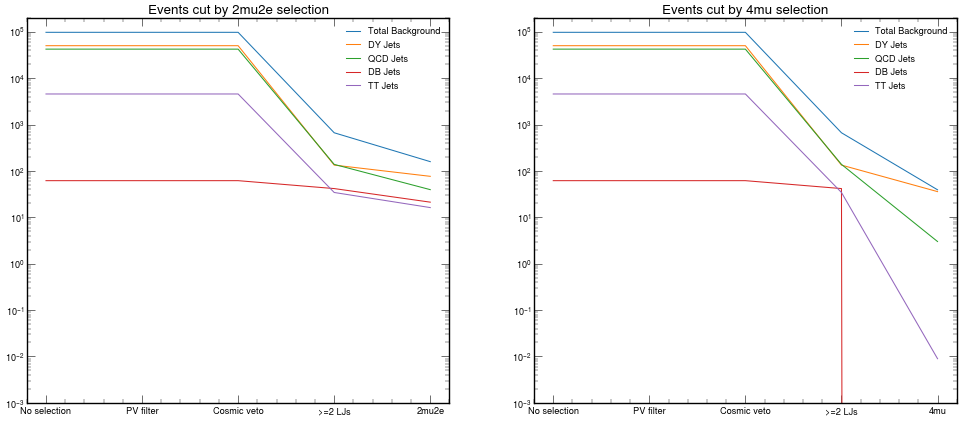

In [25]:
plt.subplots(1,2,figsize=(24,10))
plt.subplot(1,2,1)
for i in range(len(cutValues_2mu2e)):
    plt.plot(cuts_2mu2e, cutValues_2mu2e[i])
    plt.yscale("log")
    plt.ylim([.001,200000])
plt.legend(headers)
plt.title("Events cut by 2mu2e selection")

plt.subplot(1,2,2)
for i in range(len(cutValues_4mu)):
    plt.plot(cuts_4mu, cutValues_4mu[i])
    plt.yscale("log")
    plt.ylim([.001,200000])
plt.legend(headers)
plt.title("Events cut by 4mu selection")

/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


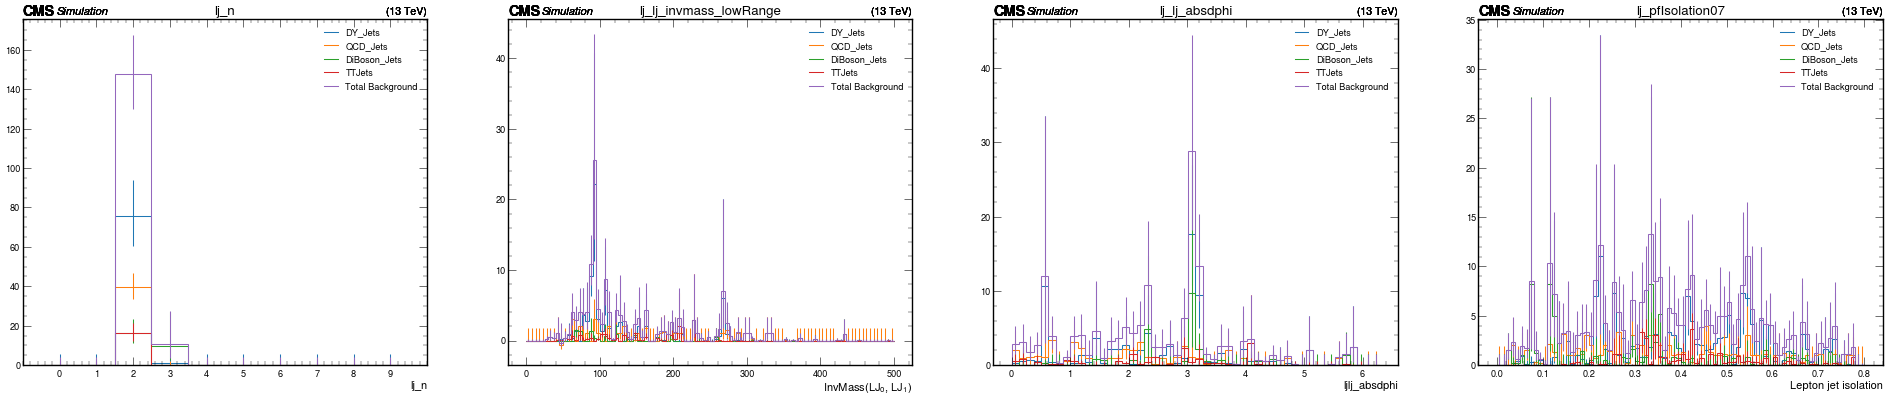

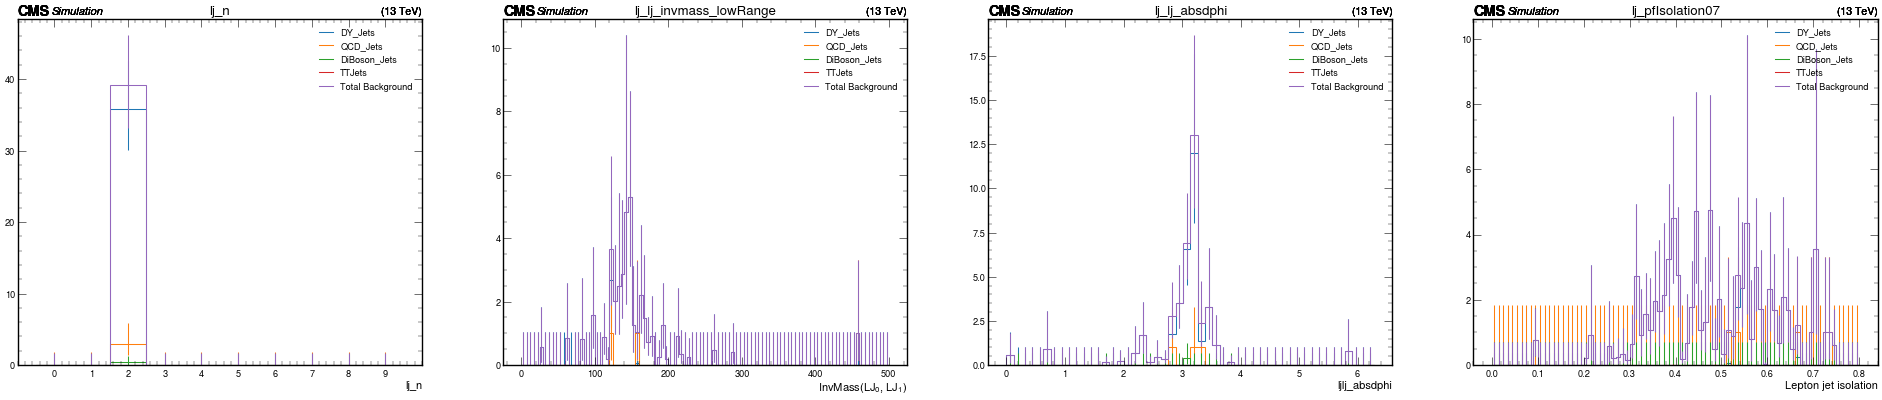

In [16]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]
plotHists(["lj_n", "lj_lj_invmass_lowRange", "lj_lj_absdphi", "lj_pfIsolation07"], "2mu2e", True, False, temp)

plotHists(["lj_n", "lj_lj_invmass_lowRange", "lj_lj_absdphi", "lj_pfIsolation07"], "4mu", True, False, temp)

In [41]:
init_cutflow.print_multi_table(cutflows_4mu, headers, fraction=False, unweighted=False)
print(DY_Cutflow["4mu"].efficiency()*100)
print(QCD_Cutflow["4mu"].efficiency()*100)
print(DiBoson_Cutflow["4mu"].efficiency()*100)
print(TT_Cutflow["4mu"].efficiency()*100)

cut name            Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                Total Background         DY Jets        QCD Jets         DB Jets         TT Jets
------------  ------------------  --------------  --------------  --------------  --------------
No selection             97462.2         50149.6         42288.3            61.7          4563.1
PV filter                97462.2         50149.6         42288.3            61.7          4563.1
Cosmic veto              97421.1         50143.9         42254.0            61.7          4561.9
>=2 LJs                    665.0           133.6           138.4            41.7            34.3
4mu                         39.2            35.8             3.0             0.0             0.0


0.07140057859942317
0.007102457311702892
0.0
0.00019590013380366145


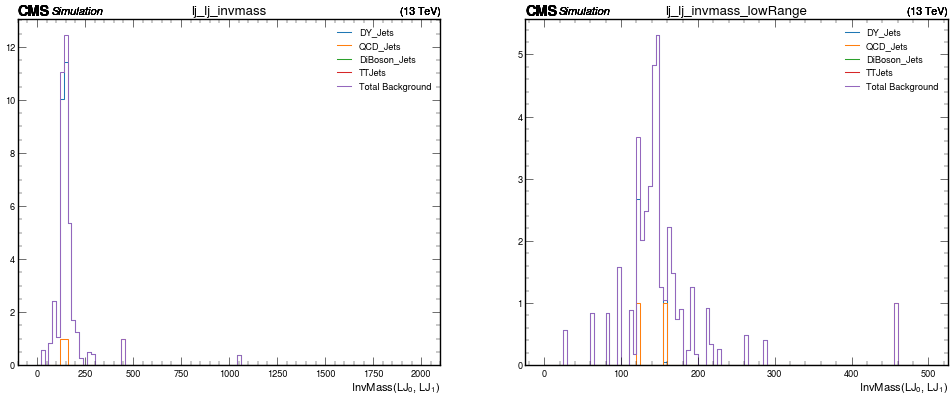

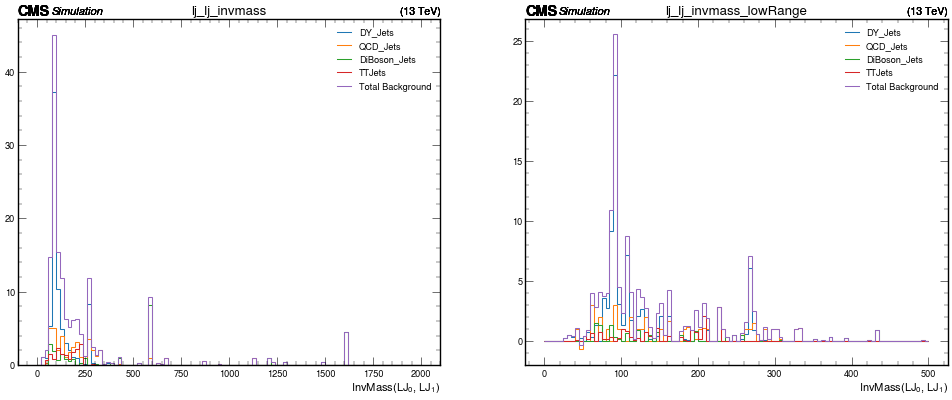

In [18]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

plotHists(["lj_lj_invmass", "lj_lj_invmass_lowRange"], "4mu", False, False, temp)
plotHists(["lj_lj_invmass", "lj_lj_invmass_lowRange"], "2mu2e", False, False, temp)

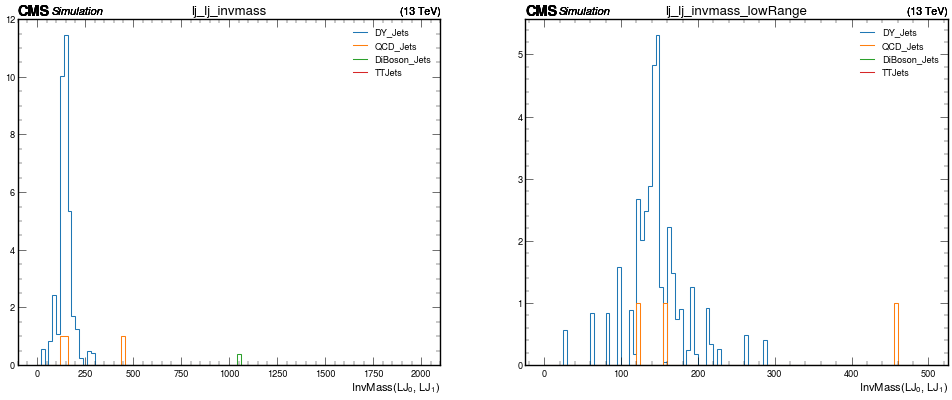

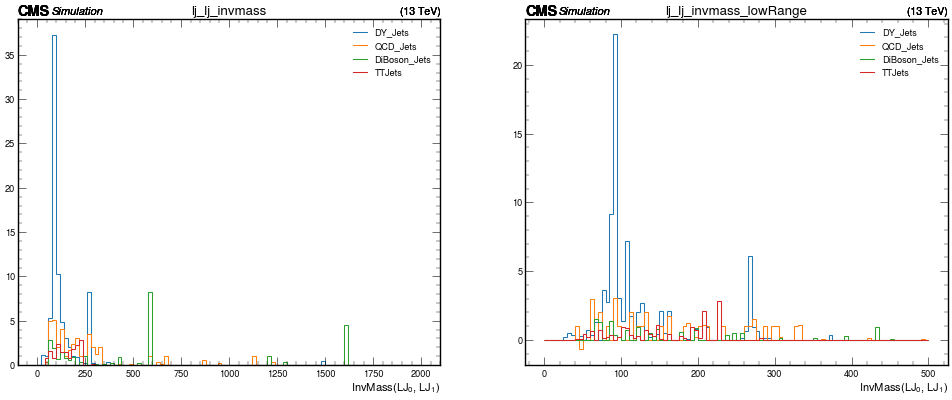

In [19]:
temp = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets"]

plotHists(["lj_lj_invmass", "lj_lj_invmass_lowRange"], "4mu", False, False, temp)
plotHists(["lj_lj_invmass", "lj_lj_invmass_lowRange"], "2mu2e", False, False, temp)

Text(0.5, 1.0, 'Invariant Mass')

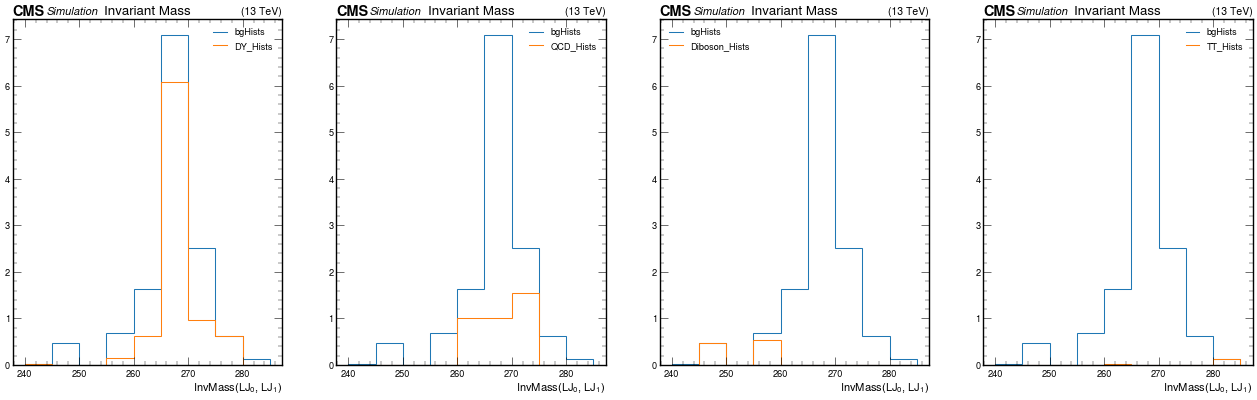

In [20]:
plt.subplots(1,4,figsize=(32,9))
plt.subplot(1,4,1)
utilities.plot([bg_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j], DY_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j]], yerr=False, density=False, flow='none')
plt.legend(["bgHists", "DY_Hists"])
plt.title("Invariant Mass")
plt.subplot(1,4,2)
utilities.plot([bg_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j], QCD_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j]], yerr=False, density=False, flow='none')
plt.legend(["bgHists", "QCD_Hists"])
plt.title("Invariant Mass")
plt.subplot(1,4,3)
utilities.plot([bg_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j], DiBoson_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j]], yerr=False, density=False, flow='none')
plt.legend(["bgHists", "Diboson_Hists"])
plt.title("Invariant Mass")
plt.subplot(1,4,4)
utilities.plot([bg_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j], TT_Hists["lj_lj_invmass_lowRange"]["2mu2e", 240j:290j]], yerr=False, density=False, flow='none')
plt.legend(["bgHists", "TT_Hists"])
plt.title("Invariant Mass")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fc0c45a8310>, errorbar=None, legend_artist=None)]

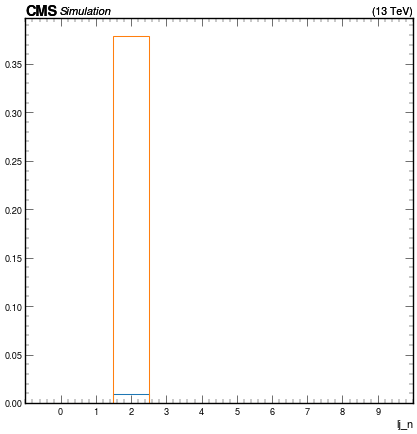

In [40]:
utilities.plot(TT_Hists["lj_n"]["4mu", :], yerr=False, density=False, flow='none')
utilities.plot(DiBoson_Hists["lj_n"]["4mu", :], yerr=False, density=False, flow='none')